In [1]:
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta

In [2]:
# start_ts = 1204329600  # 2008-03-01
start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '192.5.5.241'
prefix6 = '2001:500:2f::f'

#### helper function

In [4]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

#### calculatIon

In [5]:
utc = pytz.utc
with open('f-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
        
        bgp_state4, peer4 = get_peers(prefix4, timestamp)
        bgp_state6, peer6 = get_peers(prefix6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)
    
    

2008-03-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=1204329600
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2f::f&timestamp=1204329600
2008-04-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=1207008000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2f::f&timestamp=1207008000
2008-05-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=1209600000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2f::f&timestamp=1209600000
2008-06-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=1212278400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2f::f&timestamp=1212278400
2008-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=12148704

### Plot some graphs

In [6]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [7]:
df = pd.read_csv('f-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2008-03-01,6,3,0,5
2008-04-01,0,0,0,0
2008-05-01,0,0,1,0
2008-06-01,0,0,0,0
2008-07-01,1,0,0,1
2008-08-01,0,0,0,0
2008-09-01,0,0,0,0
2008-10-01,0,0,0,0
2008-11-01,0,0,0,0


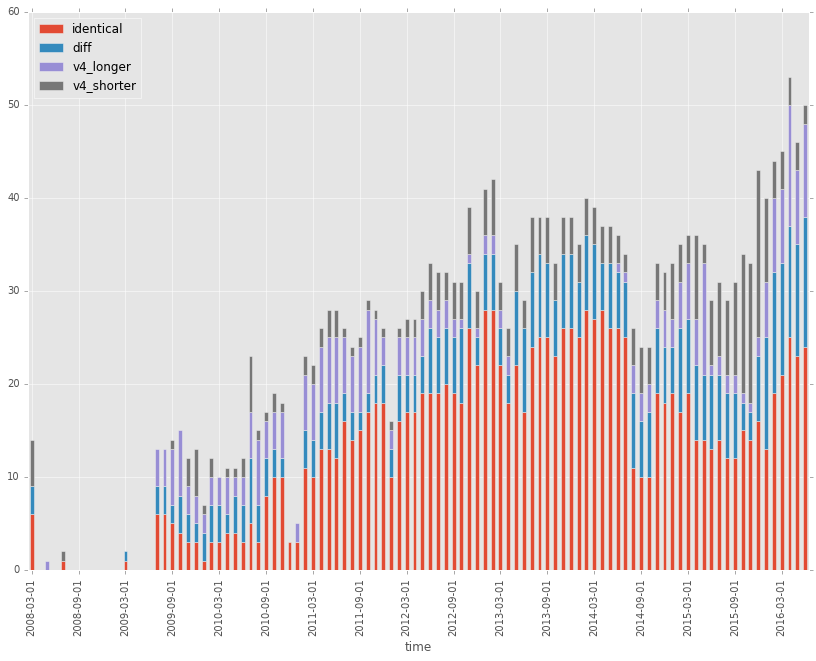

In [12]:
plot = df.plot.bar(stacked=True, figsize=(14,10))

n = 6

ticks = plot.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in plot.xaxis.get_ticklabels()]
plot.xaxis.set_ticks(ticks[::n])
plot.xaxis.set_ticklabels(ticklabels[::n])

plt.show()

# RQ: How different is IPv4 and IPv6 catchment areas?

The following RQs illustrate catchment area differences at a specific time (1464739200, or 2013-06-01)

## RQ.1 IPv4/IPv6 peer degree distribution?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

matplotlib.style.use('ggplot')

timestamp = 1464739200 # 2013-06-01

prefix4 =  '192.5.5.241'
prefix6 = '2001:500:2f::f'

Find the mutual peers

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.5.5.241&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2f::f&timestamp=1464739200


then, find mutual peers with different path

In [3]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer]['path'] != data6[peer]['path']:
        mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}

Data processing 

In [4]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,path4,collector,path6,len4,len6
286,"[286, 7922, 33491, 3557]","LINX, London","[286, 30132, 3557]",4.0,3.0
6453,"[6453, 7922, 33491, 3557]","AMS-IX and NL-IX, Amsterdam","[6453, 1280, 3557]",4.0,3.0
8758,"[8758, 8220, 33072, 3557]","SwissIX, Zurich","[8758, 6939, 30122, 3557]",4.0,4.0
9002,"[9002, 30124, 3557]","Moscow, Russia","[9002, 30132, 3557]",3.0,3.0
9189,"[9189, 25074, 30132, 3557]","Frankfurt, Germany","[9189, 6939, 33082, 3557]",4.0,4.0
9304,"[9304, 4635, 23709, 3557]","New York (NY), USA","[9304, 6939, 30122, 3557]",4.0,4.0
13030,"[13030, 1280, 394070, 3557]","New York (NY), USA","[13030, 33082, 3557]",4.0,3.0
15547,"[15547, 43531, 30132, 3557]","France-IX, Paris","[15547, 6939, 30122, 3557]",4.0,4.0
15605,"[15605, 174, 7922, 33491, 3557]","Milan, Italy","[15605, 6939, 33077, 3557]",5.0,4.0
16735,"[16735, 22548, 30122, 3557]","Sao Paulo, Brazil","[16735, 6939, 30122, 3557]",4.0,4.0


### Plot

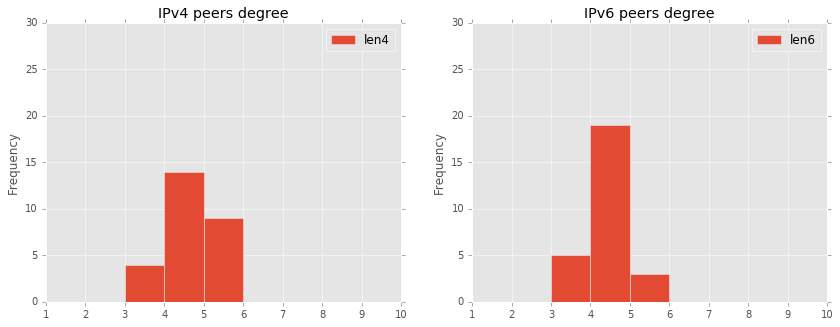

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0,30), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0,30), title='IPv6 peers degree')

plt.show()

## RQ.2 AS path average length?

In [7]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 4.185185185185185
IPv6 average path length: 3.925925925925926


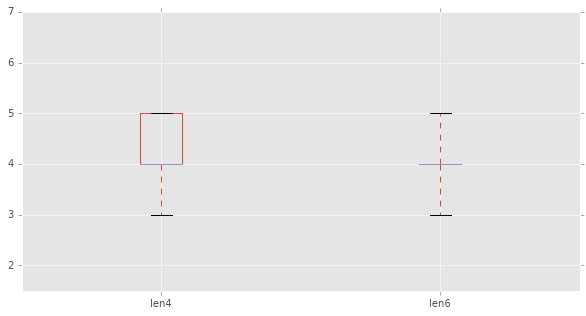

In [8]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1.5,7))
plt.show()

## RQ.3 ASes most frequently seen?

### IPv4

In [9]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
33491	6
7922	6
30126	4
30132	4
13030	3
174	3
33082	3
6939	2
8220	2
30122	2
33072	2
1280	1
43531	1
9044	1
394070	1
3257	1
15576	1
23709	1
39326	1
24611	1
4635	1
31400	1
51945	1
30124	1
30130	1
3549	1
33073	1
25074	1
6453	1
22548	1
29691	1
12586	1
33077	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [10]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	33491	6
	30126	4
	30132	4
	33082	3
	30122	2
	33072	2
	30124	1
	33073	1
	30130	1
	33077	1
	394070	1
	23709	1
(*) Hop 2:
	7922	6
	13030	3
	6939	2
	8220	2
	1280	1
	4635	1
	31400	1
	28329	1
	9002	1
	43531	1
	25074	1
	22548	1
	28917	1
	198290	1
	3257	1
	9044	1
	3549	1
	39326	1
(*) Hop 3:
	174	3
	29691	2
	6453	2
	25152	1
	20612	1
	9189	1
	13030	1
	51945	1
	12586	1
	15576	1
	202194	1
	24611	1
	8758	1
	198249	1
	9304	1
	41497	1
	15547	1
	286	1
	16735	1
(*) Hop 4:
	15605	1
	62567	1
	196621	1
	56730	1
	57821	1
	50300	1
	51405	1
	57118	1
	28941	1


### IPv6

In [11]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
6939	20
30122	14
30132	4
33077	3
33082	3
1280	1
6661	1
1836	1
51945	1
30124	1
30126	1
15576	1
3257	1


most frequently seen ASes per degere

In [12]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	30122	14
	30132	4
	33077	3
	33082	3
	1280	1
	30124	1
	30126	1
(*) Hop 2:
	6939	20
	6453	1
	13030	1
	3257	1
	9002	1
	1836	1
	286	1
	28917	1
(*) Hop 3:
	25152	1
	20612	1
	6661	1
	28941	1
	51405	1
	9304	1
	202194	1
	15576	1
	41497	1
	57821	1
	57118	1
	16735	1
	29691	1
	9189	1
	62567	1
	198249	1
	51945	1
	15605	1
	8758	1
	28329	1
	15547	1
	50300	1
(*) Hop 4:
	56730	1
	196621	1
	198290	1


## RQ.4 For shorter IPv6 path, which ASes frequently appear as transit?

In [13]:
temp= []
for item in processed_data.iterrows():
#     print(item[1]['path4'])
    if item[1]['len4'] > item[1]['len6']:
#         print('v4: {}\tv6: {}'.format(item[1]['path4'], item[1]['path6']))
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))

6939	7
30122	3
33077	2
33082	2
1280	1
30132	1
30126	1


## RQ.5 For peers with same path length but different path, how different is it?

calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [15]:
temp = []
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4'])
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))

Peer 8758: 	length:4 	difference: 50.0%
Peer 9002: 	length:3 	difference: 33.33333333333333%
Peer 9189: 	length:4 	difference: 50.0%
Peer 9304: 	length:4 	difference: 50.0%
Peer 15547: 	length:4 	difference: 50.0%
Peer 16735: 	length:4 	difference: 25.0%
Peer 20612: 	length:4 	difference: 50.0%
Peer 25152: 	length:4 	difference: 25.0%
Peer 28917: 	length:3 	difference: 33.33333333333333%
Peer 29691: 	length:4 	difference: 50.0%
Peer 41497: 	length:4 	difference: 50.0%
Peer 56730: 	length:5 	difference: 40.0%
Peer 196621: 	length:5 	difference: 40.0%
Peer 198249: 	length:4 	difference: 50.0%
Peer 202194: 	length:4 	difference: 25.0%

Most common ASes appear in IPv6 path that differs with IPv4 path
	6939	10
	30122	9
	30132	2
	33077	1
	30124	1
	1836	1
	33082	1


## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)?

In [17]:
peer_location = processed_data.groupby('collector')
peer_location['collector'].count().sort_values(ascending=False)

collector
SwissIX, Zurich                7
New York (NY), USA             3
Milan, Italy                   3
France-IX, Paris               3
Sao Paulo, Brazil              2
RIPE NCC, Amsterdam            2
Moscow, Russia                 2
LINX, London                   2
Miami, USA                     1
Frankfurt, Germany             1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv6 path?

In [18]:
v6_shorter = processed_data[processed_data.len4 > processed_data.len6].groupby('collector')
v6_shorter['collector'].count().sort_values(ascending=False)

collector
RIPE NCC, Amsterdam            2
New York (NY), USA             2
Milan, Italy                   2
SwissIX, Zurich                1
LINX, London                   1
France-IX, Paris               1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv4 path?

In [19]:
v4_shorter = processed_data[processed_data.len4 < processed_data.len6].groupby('collector')
v4_shorter['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil    1
France-IX, Paris     1
Name: collector, dtype: int64

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?

Note that here we only use mutual peers that have different IPv4/IPv6 path

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

utc = pytz.utc

start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '192.5.5.241'
prefix6 = '2001:500:2f::f'

csv_dir = 'datasets/f/'

*Helper methods*

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
#     print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    data4, peer4 = get_peers(prefix4, timestamp)
    data6, peer6 = get_peers(prefix6, timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
    #     print(peer)
        if data4[peer]['path'] != data6[peer]['path']:
    #         print(data4[peer]['path'])
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

### Get data, write to .csv file

Do it only once!!!

In [23]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = '{}{}-path.csv'.format(csv_dir, timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


### Data Analysis

get peer's degree for both IPv4 and IPv6

In [3]:
import os

In [4]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


#### Plot

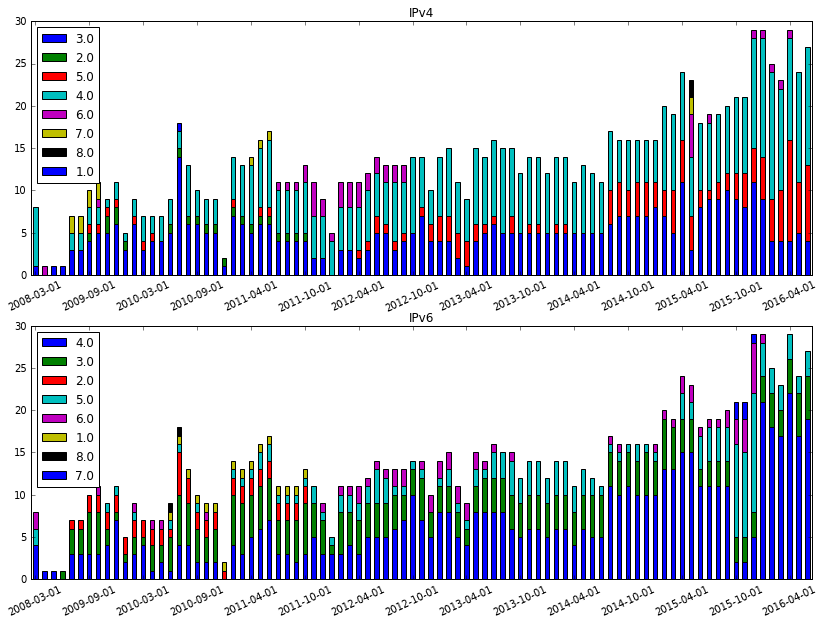

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)

plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], figsize=(14,10), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], figsize=(14,10), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

/home/arif/Github/Thesis-Code/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


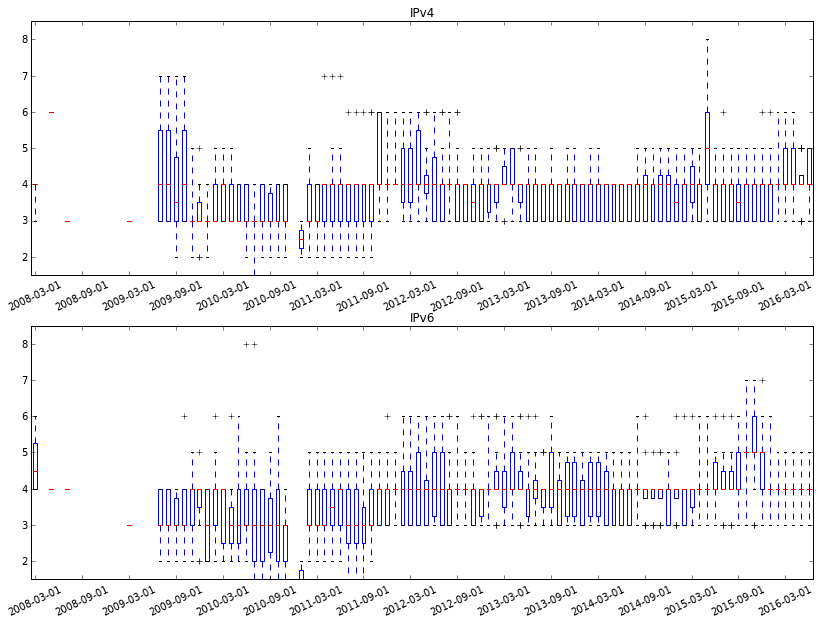

In [6]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,8.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,8.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.3 Most frequently seen ASes on the path?

### IPv4

In [7]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2008-03-01):
1280	7
174	6
20562	1
30132	1

[*] Most frequently seen ASes in IPv4 AS paths (2008-05-01):
1280	1
35244	1
41692	1
174	1

[*] Most frequently seen ASes in IPv4 AS paths (2008-07-01):
27319	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-03-01):
1280	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-07-01):
20965	2
27750	2
27859	2
20312	2
27807	2
6695	1
30124	1
30128	1
33073	1
30132	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-08-01):
20965	2
27750	2
27859	2
20312	2
27807	2
6695	1
30124	1
30128	1
33073	1
30132	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-09-01):
30132	3
20965	2
27750	2
27859	2
20312	2
27807	2
5392	1
6695	1
30124	1
30128	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-10-01):
27750	3
27859	3
20312	3
27807	3
20965	2
30132	2
33082	2
5392	1
6695	1
30124	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-11-01):
30132	2
30128	1
5392	1
30134	1
3257	1
33081	1
30124	1
3

### IPv6

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2008-03-01):
6453	3
27319	3
3257	3
30126	3
30128	2
2497	2
6175	2
5539	1
20640	1
35244	1

[*] Most frequently seen ASes in IPv6 AS paths (2008-05-01):
30132	1
41692	1

[*] Most frequently seen ASes in IPv6 AS paths (2008-07-01):
3257	1
27319	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-03-01):
3257	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-07-01):
30132	3
13237	1
13030	1
27319	1
3257	1
30071	1
3356	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-08-01):
30132	4
13237	1
13030	1
30071	1
3257	1
3356	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-09-01):
30132	3
6939	3
13237	1
3303	1
3257	1
3356	1
33081	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-10-01):
6939	3
30132	2
33081	2
20080	1
11537	1
1299	1
5539	1
20965	1
3257	1
3303	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-11-01):
6939	5
33071	5
30132	2
3549	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-12-01):
6939	5
330

## RQ.4a For shorter IPv6 path, which ASes frequently appear as transit?

In [9]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2008-03-01:
[*] at 2008-04-01:
[*] at 2008-05-01:
	30132	1
	41692	1
[*] at 2008-06-01:
[*] at 2008-07-01:
[*] at 2008-08-01:
[*] at 2008-09-01:
[*] at 2008-10-01:
[*] at 2008-11-01:
[*] at 2008-12-01:
[*] at 2009-01-01:
[*] at 2009-02-01:
[*] at 2009-03-01:
[*] at 2009-04-01:
[*] at 2009-05-01:
[*] at 2009-06-01:
[*] at 2009-07-01:
	3257	1
	30071	1
	3356	1
	13030	1
	27319	1
[*] at 2009-08-01:
	3356	1
	30071	1
	30132	1
	13030	1
	3257	1
[*] at 2009-09-01:
	6939	2
	3257	1
	3356	1
	33081	1
	3303	1
[*] at 2009-10-01:
	6939	2
	33081	2
	20080	1
	11537	1
	1299	1
[*] at 2009-11-01:
	6939	1
	33071	1
[*] at 2009-12-01:
	20080	1
	11537	1
[*] at 2010-01-01:
[*] at 2010-02-01:
	6939	1
	33071	1
[*] at 2010-03-01:
	6939	1
	33071	1
[*] at 2010-04-01:
	33081	1
	6939	1
	33071	1
[*] at 2010-05-01:
[*] at 2010-06-01:
	30071	1
[*] at 2010-07-01:
[*] at 2010-08-01:
	6939	1
	30132	1
	30071	1
[*] at 2010-09-01:
	30132	1
[*] at 2010-10-01:
	30132	1
[*] at 2010-11-01:
	6762	1
	30132	1
[*] at 2010-12-01:
[

## RQ.4b For shorter IPv6 path, how different is it?

In [10]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
34225	6	4	2	33.33%

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-08-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-09-01
----------------

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [11]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [11]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5b For shorter IPv4 path, how different is it?

In [12]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
2497	3	4	1	25.00%
2857	4	5	1	20.00%
6762	4	6	2	33.33%
8447	4	5	1	20.00%
12779	4	6	2	33.33%

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
2497	3	4	1	25.00%

---------------------------------------------------------------
 date: 2008-08-01
---------------------------------------------------------------

--------

## RQ.6 For peers with same AS path length but different path, how different is it?

In [12]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))



---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-07-01
-------------------------------------------------------------

## RQ.7 Can we correlate the path difference to their physical location?

In [13]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
collector
Frankfurt, Germany             3
Palo Alto, USA                 2
VIX, Vienna                    1
Milan, Italy                   1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
collector
Palo Alto, USA    1
Name: collector, dtype: int64

-----------------

### which collectors see the most peers with shorter IPv6 path?

In [14]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------------------------
collector
VIX, Vienna            1
RIPE NCC, Amsterdam    1
LINX, London  

### which collectors see the most peers with shorter IPv4 path?

In [15]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
collector
Palo Alto, USA        2
VIX, Vienna           1
Milan, Italy          1
Frankfurt, Germany    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------